In [2]:
import os
os.chdir('..')

In [3]:
import sys

import pandas as pd

from src.construct import util
idx = pd.IndexSlice

In [45]:
vehicle_kms = pd.read_csv(
    'https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_tf_veh.tsv.gz',
    delimiter='\t', index_col=0
)
vehicle_kms.index = vehicle_kms.index.str.split(',', expand=True).rename(['reg_type', 'unit', 'vehicle', 'country_code'])
vehicle_kms = vehicle_kms.apply(util.to_numeric)

vehicle_types = {
    'TOTAL': ('Total', 'total'),
    'LOR': ('lorries', 'diesel'),
    'LOR_LE3P5': ('lorries_small', 'diesel'),
    'LOR_GT3P5-6': ('lorries_medium', 'diesel'),
    'LOR_GT6': ('lorries_big', 'diesel'),
    'TRC': 	('tractors', 'diesel'),
    'MOTO_MOP': ('motorcycles', 'diesel'),
    'CAR': ('passenger_cars', 'total'),
    'CAR_PET': ('passenger_cars', 'petrol'),
    'CAR_DIE': ('passenger_cars', 'diesel'),
    'CAR_OTH': ('passenger_cars', 'other'),
    'BUS_TOT': 	('buses', 'diesel'),
    'MTZ_OTH': 	('other', 'other')
}

In [46]:
vehicle_kms = (
    vehicle_kms
    .xs(('D005', 'MIO_VKM'))
    .unstack('country_code')
)
vehicle_kms.index = vehicle_kms.index.map(vehicle_types)
vehicle_kms= vehicle_kms.groupby(level=0).sum(min_count=1)
vehicle_kms.index = pd.MultiIndex.from_tuples(vehicle_kms.index).rename(['vehicle', 'carrier'])

# Rail profiles

In [122]:
profiles.columns

Index(['0.00', '1.00', '2.00', '3.00', '4.00', '5.00', '6.00'], dtype='object')

In [161]:
profiles = pd.read_csv('data/transport/rail_daily_profiles_destinee.csv', index_col=0, header=0)
profiles.columns = profiles.columns.astype(float)
profiles.index = profiles.index.astype(float)

In [162]:
profiles

,0.0,1.0,2.0,3.0,4.0,5.0,6.0
0.0,0.012301,0.012301,0.012301,0.012301,0.012301,0.013967,0.011315
1.0,0.002083,0.002083,0.002083,0.002083,0.002083,0.002962,0.007926
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001189,0.004461
3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001791
4.0,0.002609,0.002609,0.002609,0.002609,0.002609,0.002962,0.001791
5.0,0.013212,0.013212,0.013212,0.013212,0.013212,0.008053,0.004461
6.0,0.049384,0.049384,0.049384,0.049384,0.049384,0.015501,0.009630
7.0,0.070758,0.070758,0.070758,0.070758,0.070758,0.031298,0.019463
8.0,0.074476,0.074476,0.074476,0.074476,0.074476,0.051108,0.030122
9.0,0.069557,0.069557,0.069557,0.069557,0.069557,0.064848,0.044590


In [277]:
rail_profile = pd.Series(index=pd.date_range('2016', '2017', freq='1H'))

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


2016-01-01 00:00:00   NaN
2016-01-01 01:00:00   NaN
2016-01-01 02:00:00   NaN
2016-01-01 03:00:00   NaN
2016-01-01 04:00:00   NaN
                       ..
2016-12-31 19:00:00   NaN
2016-12-31 20:00:00   NaN
2016-12-31 21:00:00   NaN
2016-12-31 22:00:00   NaN
2016-12-31 23:00:00   NaN
Freq: H, Length: 8784, dtype: float64

In [183]:
annual_profiles = pd.merge(
    rail_profile.groupby([rail_profile.index.date, rail_profile.index.hour, rail_profile.index.dayofweek]).sum().rename_axis(index=['date', 'hour', 'dayofweek']).rename('delete_me'), 
    profiles.dropna(axis=1).stack().rename_axis(index=['hour', 'dayofweek']).rename('profiles'),
    left_index=True, right_index=True
).drop('delete_me', axis=1)
annual_profiles.index = pd.to_datetime(annual_profiles.index.get_level_values('date')) + pd.to_timedelta(annual_profiles.index.get_level_values('hour').astype(int), unit='h')
annual_profiles = annual_profiles.sort_index()

In [184]:
annual_profiles

,profiles
2016-01-01 00:00:00,0.012301
2016-01-01 01:00:00,0.002083
2016-01-01 02:00:00,0.000000
2016-01-01 03:00:00,0.000000
2016-01-01 04:00:00,0.002609
...,...
2016-12-31 19:00:00,0.055804
2016-12-31 20:00:00,0.046476
2016-12-31 21:00:00,0.035362
2016-12-31 22:00:00,0.032131


In [139]:
import pytz

In [179]:
def _shift_profiles(profile, country, model_year):
    """
    Shift profiles forward/backward in time based on region timezones
    """
    tz = pytz.country_timezones[country][0]
    try:
        idx = profile.index.tz_localize(tz, nonexistent='shift_forward').tz_convert('UTC')
    except pytz.AmbiguousTimeError as err:
        idx = profile.index.tz_localize(
            tz, ambiguous=profile.index != err.args[0], nonexistent='shift_forward'
        ).tz_convert('UTC')
    shift = len(idx[idx.year > model_year]) - len(idx[idx.year < model_year])
    profile = np.roll(profile, shift=shift)
    return profile

In [185]:
for i in ['PT', 'GB', 'DE', 'GR']:
    annual_profiles[i] = _shift_profiles(annual_profiles['profiles'], i, 2016)


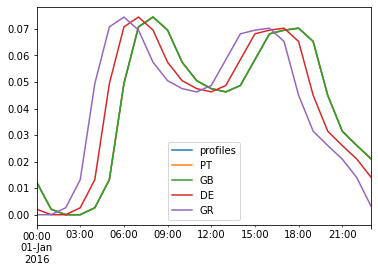

In [187]:
annual_profiles.iloc[0:24].plot()

In [151]:
import numpy as np

In [210]:
pd.read_csv("build/annual_industry_energy_demand.csv", index_col=[0, 1, 2, 3, 4, 5, 6], squeeze=True).sum(level=['carrier', 'vehicle_type', 'country_code', 'year']).xs('electricity')

,subsector,country_code,unit,carrier,year,0
0,Iron and steel,FR,twh,electricity,1950.0,26.227661
1,Iron and steel,FR,twh,electricity,1960.0,26.227661
2,Iron and steel,FR,twh,electricity,1970.0,26.227661
3,Iron and steel,FR,twh,electricity,1978.0,26.227661
4,Iron and steel,FR,twh,electricity,1979.0,26.227661
...,...,...,...,...,...,...
56695,Wood and wood products,RS,twh,space_heating,2015.0,0.007534
56696,Wood and wood products,RS,twh,space_heating,2016.0,0.002053
56697,Wood and wood products,RS,twh,space_heating,2017.0,0.002053
56698,Wood and wood products,RS,twh,space_heating,2018.0,0.002053


In [239]:
energy_balances = pd.read_csv('build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [1]:
ramp_mobility_countries = [
    "AT", "BE", "BG", "CH", "CZ", "DE", 
    "DK", "EE", "ES", "FI", "FR", "HR", 
    "HU", "IE", "IT", "LT", "LU", "LV", 
    "NL", "NO", "PL", "PT", "RO", "SE", 
    "SI", "SK", "UK"
]

In [2]:
for i in ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK',
       'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UK']:
    if i not in ramp_mobility_countries:
        print(i)

AL
BA
EL
IS
ME
MK
RS


In [7]:
CARRIERS = {
    'O4652XR5210B': 'petrol',
    'R5210B': 'biofuels',
    'O4671XR5220B': 'diesel',
    'R5220B': 'biofuels',
    'O4630': 'lpg',
    'G3000': 'natural_gas',
    'E7000': 'electricity'
}
idx = pd.IndexSlice

In [4]:
energy_balances = util.read_tdf('build/annual_energy_balances.csv')

In [5]:
other_transport_aviation = (  # all kerosene from the military destined for aviation
    energy_balances
    .loc[idx['FC_OTH_NSP_E', ['O4651', 'O4653', 'O4661XR5230B', 'O4669'], :, :, :]]
    .sum(level=['country', 'year'])
)
other_transport_road = (  # i.e. all oil that isn't destined for aviation
    energy_balances
    .loc[idx[['FC_OTH_AF_E', 'FC_OTH_NSP_E'], 'O4000XBIO', :, :, :]]
    .sum(level=['country', 'year'])
    .sub(other_transport_aviation, fill_value=0)  # remove fuel use assumed for aviation
    .to_frame('diesel')
    .rename_axis(columns='carrier')
    .stack()
)

In [20]:
model_year = 2016
transport_energy_balance = (
    energy_balances
    .xs('FC_TRA_ROAD_E')
    .unstack('carrier_code')
    .groupby(CARRIERS, axis=1).sum(min_count=1)
    .rename_axis(columns='carrier')
    .droplevel('unit')
    .stack()
#    .add(other_transport_road)
    .apply(util.tj_to_twh)
    .rename_axis(index=['country_code', 'year', 'carrier'])
)
transport_energy_balance_2 = (
    energy_balances
    .xs('FC_TRA_ROAD_E')
    .unstack('carrier_code')
    .groupby(CARRIERS, axis=1).sum(min_count=1)
    .rename_axis(columns='carrier')
    .droplevel('unit')
    .stack()
    .add(other_transport_road, fill_value=0)
    .apply(util.tj_to_twh)
    .rename_axis(index=['country_code', 'year', 'carrier'])
)

In [21]:
(transport_energy_balance - transport_energy_balance_2).sum()

-6124.128084166667